# Mini-Project-1 : Autonomous Mobile Robot

## Anirban Sinha

The project focuses on the control of a mobile robot that intends to go from a given initial position to a desired goal position. The robt has to generate a path from initial to final position while avoiding obstacles simulteneously. The robot here is considered as a point mass having the following dynamics equations,
\begin{eqnarray}
F & = & Ma  \\
\ddot{x} & = & u_x \\
\ddot{y} & = & u_y
\end{eqnarray}
We further assume that no turning constraint or angle constraints are imposed on the robot model for this project. In other words, the robot can move in the $XY$ plane freely.

In this project we performed broadly the following tasks,

1. Generated mesh grid and put obstacles in the grid

2. Use Dynamic Programing to figure out the path that avoids obstacles while simulteneously moving from initial to goal

3. Test the algorithm with different buffer size around the obstacles

4. Smoothing the way-points in the path

5. Generating trajectory that follows uniform speed of 1.5 through out the path

6. Designing a Control-Law considering Actuator-Constraints while tracking the desired trajectory

7. Designing an Observer by Reduced-Order-Observer method

8. Implementing Seperation-Principle to combine Controller and Observer


### 1. Grid and Obstacle generation
Here we create a mesh grid of size 10-by-10 having resolutions in x as 0.1 and in y 0.1 respectively. We generated obstacles by MATLAB's patch function. The obstacles can be identified by the green patches in the grid.

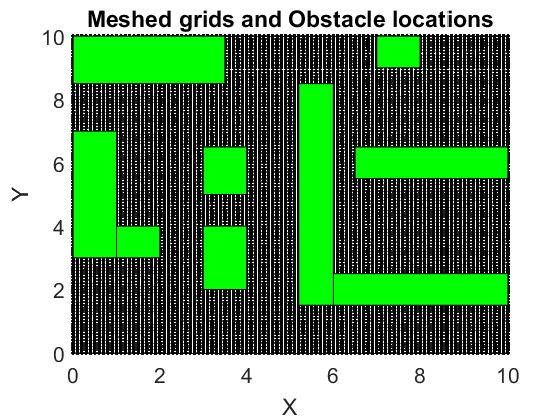

In [42]:
% Grid definition
x = 0:.1:10;
y = 0:.1:10;

% Maximum nunber of grid points
maxind = x(1,end)/0.1;

% Plot the grid as per definition
[xx,yy] = meshgrid(x,y);
figure;
plot(xx,yy,'k.')
hold on;

% Define obstacles
obs_non_buffered = [6 1.5 10 2.5;
                    6.5 5.5 10 6.5;
                    0 8.5 3.5 10;
                    0 3 1 7;
                    1 3 2 4;
                    5.2 1.5 6 8.5;
                    3 5 4 6.5;
                    7 9 8 10;
                    3 2 4 4];
                    
for i = 1:size(obs_non_buffered,1)
    patch( [obs_non_buffered(i,1) obs_non_buffered(i,1)  obs_non_buffered(i,3) obs_non_buffered(i,3)  ], ...
        [obs_non_buffered(i,2) obs_non_buffered(i,4)  obs_non_buffered(i,4) obs_non_buffered(i,2)  ],'g' );
end

xlabel('X')
ylabel('Y')
title('Meshed grids and Obstacle locations')

### 2. Generating collision free path
We use dynamic programing to compute the obstacle free path for the robot. We assign very high cost to the obstacles and lower costs to the other parts of the grid. Dynamic programing computes an optimal path that connects the initial position to goal position while avoiding the obstacles. The code that does this complete task is attached below. 

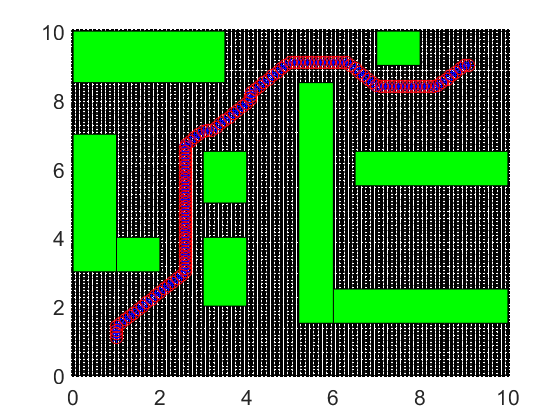

In [43]:
clc
close all
clear all

% Grid definition
x = 0:.1:10;
y = 0:.1:10;

% Maximum nunber of grid points
maxind = x(1,end)/0.1;

% Start point
x_agent = [1];
y_agent = [1];

Act = zeros(length(x),length(y));
V = zeros(length(x),length(y));

% Plot the grid as per definition
[xx,yy] = meshgrid(x,y);

figure;
plot(xx,yy,'k.')
hold on;

% Goal coordinate
x_goal = 9;
y_goal = 9;

x_start = 1;
y_start = 1;

[i_x,i_y]= xy_to_indices(x_goal,y_goal);
ix_goal = i_x;
iy_goal = i_y;

i_do_nth = [i_x,i_y];

Act(i_x,i_y) = 0;
plot(x_goal,y_goal,'ro')

% Non buffered obstacles to plot
obs_non_buffered = [6 1.5 10 2.5;
                    6.5 5.5 10 6.5;
                    0 8.5 3.5 10;
                    0 3 1 7;
                    1 3 2 4;
                    5.2 1.5 6 8.5;
                    3 5 4 6.5;
                    7 9 8 10;
                    3 2 4 4];

% Need to solve the problem
obs_locs = [6 1.5 10 2.5;
            6.5 5.5 10 7;
            0 8 4 10;
            0 3 1.5 7;
            1 3 2.5 4;
            5 1.5 6 9;
            3 5 4 7;
            7 8.5 8 10;
            3 2 4 4];

for i = 1:size(obs_locs,1)
     patch( [obs_locs(i,1) obs_locs(i,1)  obs_locs(i,3) obs_locs(i,3)  ], ...
        [obs_locs(i,2) obs_locs(i,4)  obs_locs(i,4) obs_locs(i,2)  ],'r' );    
    
    [ix_obs_st,iy_obs_st]= xy_to_indices( obs_locs(i,1), obs_locs(i,2));
    [ix_obs_en,iy_obs_en]= xy_to_indices( obs_locs(i,3), obs_locs(i,4));
    
    Act(ix_obs_st:ix_obs_en,iy_obs_st:iy_obs_en) =  200;
end

close all
figure;
% Costs at the obstacle grids
V = 4000*ones(size(Act));
gam = .9;
filename = ['Value_growth' num2str(i) '.gif'];
changed = 1;
i_V = 1;
while changed == 1
    changed = 0;
    V_old = V;
    for i_x = 1:length(x)
        for i_y = 1:length(y)
            
            if (i_x == ix_goal) &&(i_y == iy_goal)
                if V(i_x,i_y) > 0
                    changed = 1;
                    V(i_x,i_y) = 0;
                end
            end
            
            if Act(i_x,i_y) ~= 200;
                iv_x = [1 -1 0 0 1 -1 1  -1];
                iv_y = [0 0 -1 1  1 -1 -1 1];
                V_new = [];
                for i_v = 1:8,
                    val = check_ind(i_x+iv_x(i_v),i_y+iv_y(i_v),maxind);
                    if val == 1
                        V_new  = V(i_x+iv_x(i_v),i_y+iv_y(i_v)) + 10*sqrt(iv_x(i_v)^2+iv_y(i_v)^2);
                        
                        if V_new< V(i_x,i_y)
                            V(i_x,i_y) = V_new;
                            changed = 1;
                            
                        end
                    end
                end
                
                
            else
                V(i_x,i_y) = 4000;
            end
        end
    end
    
    
    surf(yy,xx,V_old);xlabel('X');ylabel('Y');zlabel('Value')
    title(['Value after ' num2str(i_V) ' iterations.'])
    % axes of cost plot
    axis([0 10 0 10 -200 5100])
    view(i_V*3,30);
    frame = getframe(1);
    im = frame2im(frame);
    [imind,cm] = rgb2ind(im,256);
    if i_V == 1;
        imwrite(imind,cm,filename,'gif', 'Loopcount',inf,'DelayTime',.1);
    else
        imwrite(imind,cm,filename,'gif','WriteMode','append','DelayTime',.1);
    end
    i_V = i_V+1;
end

for i = i_V:i_V+60
    surf(yy,xx,V);xlabel('X');ylabel('Y');zlabel('Value')
    title(['Value after ' num2str(i) ' iterations (Converged).'])
    % axes of cost plot
    axis([0 10 0 10 -200 5100])
    view(i*3,30);
    frame = getframe(1);
    im = frame2im(frame);
    [imind,cm] = rgb2ind(im,256);
    imwrite(imind,cm,filename,'gif','WriteMode','append','DelayTime',.1);
    
end

filename = ['Obs_Avoidance' num2str(i) '.gif'];
close all

figure;
plot(xx,yy,'k.')
hold on;
for i = 1:size(obs_locs,1)
    patch( [obs_non_buffered(i,1) obs_non_buffered(i,1)  obs_non_buffered(i,3) obs_non_buffered(i,3)  ], ...
        [obs_non_buffered(i,2) obs_non_buffered(i,4)  obs_non_buffered(i,4) obs_non_buffered(i,2)  ],'g' );
end

% for i = 1:size(obs_locs,1)
%     patch( [obs_locs(i,1)-0.2 obs_locs(i,1)-0.2  obs_locs(i,3)-0.2 obs_locs(i,3)-0.2], ...
%         [obs_locs(i,2)-0.2 obs_locs(i,4)-0.2  obs_locs(i,4)-0.2 obs_locs(i,2)-0.2],'g' );
% end

Va = [];
hold on;
i_move = 1;
k = 1;

for i = 1:length(x_agent)
    [i_x,i_y]= xy_to_indices(x_agent(i),y_agent(i));
    stop_mov = 0;
    while stop_mov == 0
        iv_x = [1 -1 0 0 1 -1 1  -1];
                iv_y = [0 0 -1 1  1 -1 -1 1];
        for i_v = 1:8,
            Va(i_v) = V(i_x+iv_x(i_v),i_y+iv_y(i_v)) + 10*sqrt(iv_x(i_v)^2+iv_y(i_v)^2);
        end
        
        [V_min , i_vmin]= min(Va);
        x_agent(i) = x( i_x+iv_x(i_vmin));
        y_agent(i) = y( i_y+iv_y(i_vmin));
        path_cord(1,k) = x_agent(i);
        path_cord(2,k) = y_agent(i);
        plot(x_agent(i),y_agent(i),'bx')
        plot(x_agent(i),y_agent(i),'b*')
        
        if (i_x==ix_goal)&&(i_y==iy_goal)
            stop_mov = 1;
        end
        
         frame = getframe(1);
         im = frame2im(frame);
        [imind,cm] = rgb2ind(im,256);
        if i_move == 1;
            imwrite(imind,cm,filename,'gif', 'Loopcount',inf,'DelayTime',.1);
        else
            imwrite(imind,cm,filename,'gif','WriteMode','append','DelayTime',.1);
        end
        i_move = i_move+1;       
        [i_x,i_y]= xy_to_indices(x_agent(i),y_agent(i));
        pause(0.01);
        k = k + 1;
    end
end

%%% Path smoothing and plotting
new_way = path_cord;

for i = 2:length(path_cord)-1
    new_way(:,i) = new_way(:,i) + 0.5*(path_cord(:,i) - new_way(:,i)) + 0.1*(new_way(:,i-1) - 2*new_way(:,i) + new_way(:,i+1));
end

for i = 1:length(new_way)
    plot(new_way(1,i),new_way(2,i),'ro')
    frame = getframe(1);
    im = frame2im(frame);
    pause(0.01);
end

The above code at first generates a collision free path as can be seen from the blue markers. The smooth path is shown in red markers which overlay the blue markers. However the path is not very smooth. To make it smooth we use "gradient descent" method. The points for the smooth trajectory can be found by the following equation,

\begin{equation}
\hat{XY}_{i} = \hat{XY}_{i} + \beta (XY_{i}-\hat{XY}_{i}) + \gamma (\hat{XY}_{i-1} - 2 \hat{XY}_{i} + \hat{XY}_{i+1})
\end{equation}

where $XY_i$ is the ith point on the actual path and $\hat{XY}_{i}$ denotes the ith point on the smooth path. We initialize $\hat{XY}$ with $XY$ and then we update $\hat{XY}$ by looping through the way points.
The piece of code for smoothing is presented seperatly here,

In [44]:
%Path smoothing with gradient descent method
% initialize new path with old path
new_way = path_cord;
%update the new path through a loop
for i = 2:length(path_cord)-1
    new_way(:,i) = new_way(:,i) + 0.5*(path_cord(:,i) - new_way(:,i)) + 0.1*(new_way(:,i-1) - 2*new_way(:,i) + new_way(:,i+1));
end

### 3. Comparison with different obstacle buffers

The following result shows that if we donot consider any buffer area around the obstacles the generated path touches the walls of the obstacles. This event can be seen below.

<img src="nobuffer.png">

### 5. Control Law for trajectory tracking (with Actuator Constraints)
The dynamic equation of the system under consideration is represented in state space as following,

\begin{equation}
\frac{d}{dt}\left[ \begin{array}{c} x_1 \\ x_2 \\ x_3 \\x_4 \end{array} \right] = \left[ \begin{array}{cccc} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 \end{array} \right]\left[ \begin{array}{c} x_1 \\ x_2 \\ x_3 \\ x_4 \end{array} \right] + \left[ \begin{array}{cc} 0 & 0 \\ 0 & 0 \\ 1 & 0 \\ 0 & 1 \end{array} \right] \left[ \begin{array}{c} u_x \\ u_y \end{array} \right] %]]
\end{equation}

with measurements in position only represented as following,
\begin{equation}
y = \left[ \begin{array}{cccc} 1 & 0 & 0 & 0\\
                              0 & 1 & 0 & 0\end{array} \right] X . %]]
\end{equation}

The code below is for designing a trajectory tracking controller. Code walk through,
We first load the text file in the MATLAB's command window that contains trajectory information. Next we define the dynamics of the system. The control law considers actuator constaints has the following form,

\begin{equation}
control = -K(X - X\_des)
\end{equation}

The output of the program shows that the control law is able to track the desired trajectory successfully. Also to note that here we assume that we know the information for all the states or in other words observer is not designed so far.

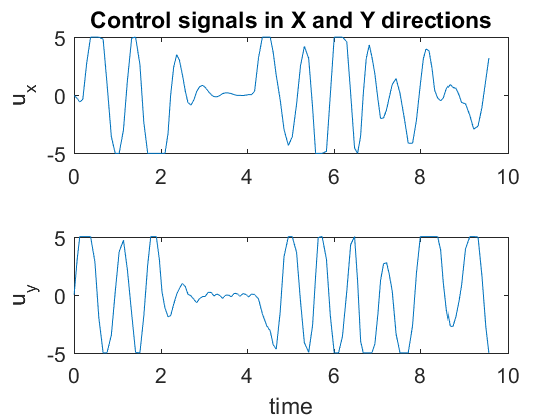

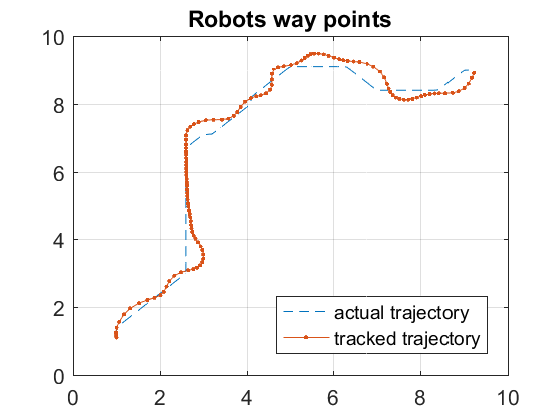

the rank of the controllability matrix is : 4


In [45]:
clc
clear all
close all

way_pts = load('smooth_way_points.txt');

A = [0 0 1 0; 0 0 0 1; 0 0 0 0; 0 0 0 0];
B = [0 0; 0 0; 1 0; 0 1];
display(['the rank of the controllability matrix is : ' num2str(rank(ctrb(A,B)))]);
p1 = zeros(2,2);
p2 = [1 0 0 0; 0 1 0 0];
p3 = zeros(4,2);
p4 = A;
p5 = zeros(2,2);

Aprime = [p1 p2;p3 p4];
Bprime = [p5;B];
p = [-2;-2.5;-3;-3.5;-4;-4.5];

K = place(Aprime,Bprime,p);
[v,d] = eig(Aprime-Bprime*K);

tspan = way_pts(:,1);
xcord = way_pts(:,2);
ycord = way_pts(:,3);

xEul = zeros(6,length(tspan));
xEul(:,1) = [0;0;xcord(1);ycord(1);0;0];
control_val = zeros(2,length(tspan));
trim_control_val = control_val;

control_saturate = @(x)[sign(x).*min(abs(x),5)];
control = @(t,x,i)[-K*(x-[0;0;xcord(i+1);ycord(i+1);0;0])];

for i = 1:length(tspan)-1
    h = tspan(i+1)-tspan(i);
    control_val(:,i+1) = control(tspan(i+1),xEul(:,i),i);
    trim_control_val(:,i+1) = control_saturate(control_val(:,i+1));
    xEul(:,i+1) = xEul(:,i) + h*(Aprime*xEul(:,i)+Bprime*control_saturate(control_val(:,i))-[xcord(i+1);ycord(i+1);0;0;0;0]);
end

figure;
plot(xcord,ycord,'--')
hold on
plot(xEul(3,:),xEul(4,:),'.-')
legend('actual trajectory','tracked trajectory','Location','SouthEast')
grid on
title('Robots way points')

figure;
subplot(2,1,1)
plot(tspan,trim_control_val(1,:))
ylabel('u_x')
title('Control signals in X and Y directions')
subplot(2,1,2)
plot(tspan,trim_control_val(2,:))
xlabel('time')
ylabel('u_y')

### 6. Observer Design (Reduced-Order-Observer) with time invarient control input

Here we design a reduced-order-observer that first checks if the system at hand is at all observable and if so then designs an observer for it. In order to check the efficacy of the obsrver we solved the same system with different initial condition and time span. The results show that observers estimates reaches the actual state values within 1 second. We placed the poles of the observer at $-10$ and $-15$. The corresponding gain is obtained as,

$$ K_z = \begin{bmatrix}
         10 & 0 \\
          0 & 15 \\
          \end{bmatrix}
          $$
          
Since we are only designing an observer without worrying about the control law we consider 

$$u = [0.5\quad0.5]^T$$

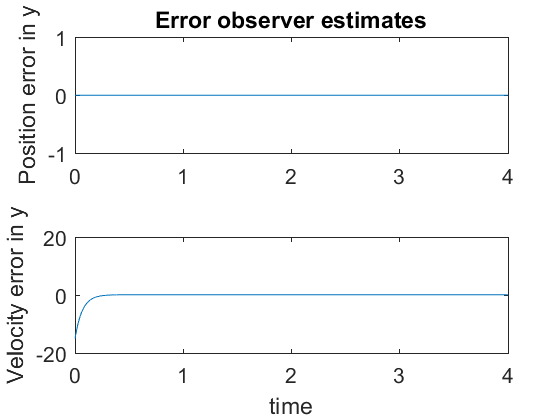

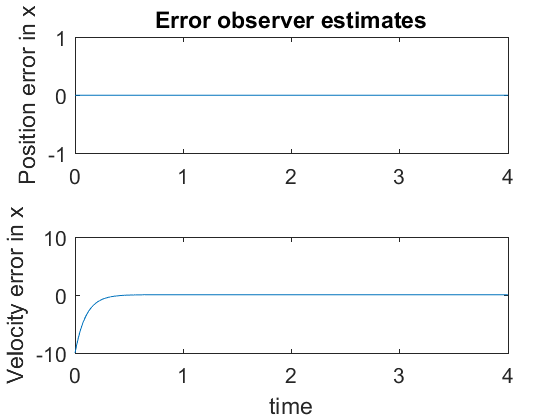

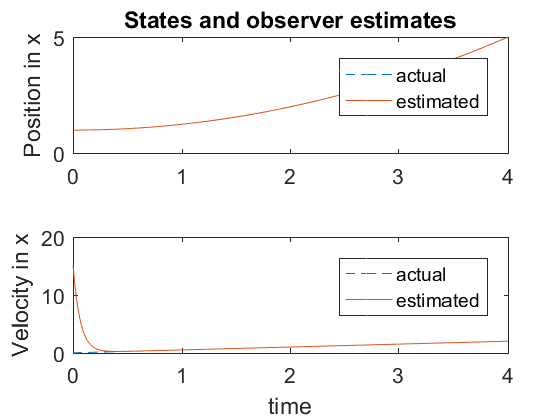

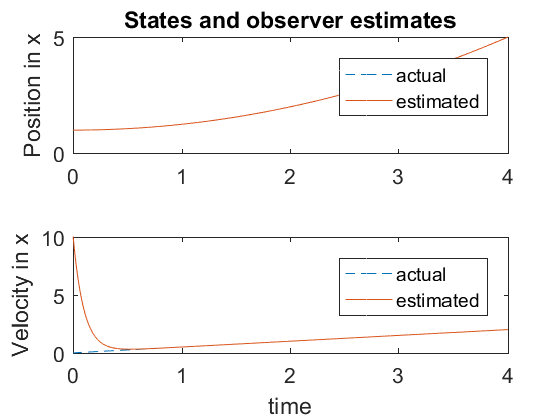

Observability matrix's rank is 4.
Poles of the observer system are at

ans =

   -15
   -10

Modified observer system is dw =  A_w2 * w + A_wz1 * z1 + B_wz u


In [46]:
clc;
close all;
clear all;

A = [0 0 1 0; 0 0 0 1; 0 0 0 0; 0 0 0 0];
B = [0 0; 0 0; 1 0; 0 1];
C = [1 0 0 0; 0 1 0 0];
P = [1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1]; % compute it
u = [0.5 0.5]';                           % change it

display(['Observability matrix''s rank is ' num2str(rank(obsv(A,C))) '.' ])

A_z = inv(P)*A*P;
B_z = inv(P)*B;
C_z = C*P;

p = 2;                                   % change
n = size(A,1);

A_z11 = A_z(1:p,1:p);
A_z12 = A_z(1:p,p+1:n);
A_z21 = A_z(p+1:n,1:p);
A_z22 = A_z(p+1:n,p+1:n);

B_z1 = B_z(1:p,1:p);
B_z2 = B_z(p+1:n,1:p);
K_z = [10 0; 0 15];                        % compute it

poles_sys = A_z22 - K_z*A_z12;
display(['Poles of the observer system are at'])
eig(A_z22 - K_z*A_z12)

A_w2 = A_z22 - K_z*A_z12;
A_wz1 = A_z21 - K_z*A_z11 + A_z22*K_z - K_z*A_z12*K_z;
B_wz = B_z2 - K_z*B_z1;

display(['Modified observer system is dw =  A_w2 * w + A_wz1 * z1 + B_wz u' ])

t = 0:0.001:4; 
dt = t(2) - t(1);
X(:,1) = [1;1;0;0];                      % change
y(:,1) = C*X;
Z_1(:,1) = y(:,1);
w(:,1) = [0;0];                          % change
Z_2(:,1) = K_z*Z_1(:,1)+w(:,1);

X_hat(:,1) = P*[Z_1(:,1);Z_2(:,1);];

for i = 2:length(t)
    % u = .5;
    
    X(:,i) = X(:,i-1)  +dt * (A*X(:,i-1) + B*u);
    y(:,i) = C*X(:,i) ;
    
    Z_1(:,i) = y(:,i);

    w(:,i) = w(:,i-1) + dt* ( A_w2*w(:,i-1) + A_wz1*Z_1(:,i-1) + B_wz * u) ;
    
    Z_2(:,i) = K_z*Z_1(:,i)+w(:,i);
   X_hat(:,i) = P*[Z_1(:,i);Z_2(:,i);];
end

figure;
subplot(2,1,1)
plot(t,X(1,:),'--',t,X_hat(1,:))
legend('actual', 'estimated')
title('States and observer estimates')
ylabel('Position in x')
subplot(2,1,2)
plot(t,X(3,:),'--',t,X_hat(3,:))
legend('actual', 'estimated')
ylabel('Velocity in x')
xlabel('time')

figure;
subplot(2,1,1)
plot(t,X(2,:),'--',t,X_hat(2,:))
legend('actual', 'estimated')
title('States and observer estimates')
ylabel('Position in x')
subplot(2,1,2)
plot(t,X(4,:),'--',t,X_hat(4,:))
legend('actual', 'estimated')
ylabel('Velocity in x')
xlabel('time')

figure;
subplot(2,1,1)
plot(t,X(1,:)-X_hat(1,:))
title('Error observer estimates')
ylabel('Position error in x')
subplot(2,1,2)
plot(t,X(3,:)-X_hat(3,:))
ylabel('Velocity error in x')
xlabel('time')

figure;
subplot(2,1,1)
plot(t,X(2,:)-X_hat(2,:))
title('Error observer estimates')
ylabel('Position error in y')
subplot(2,1,2)
plot(t,X(4,:)-X_hat(4,:))
ylabel('Velocity error in y')
xlabel('time')

### 7. Controller and Observer Combined (Seperation Principle)
Here we combine the observer and controller but they work independently as we have known from seperation principle. The poles of the observer have been considered more negetive that the poles of the controller. This makes the estimation of the states correctly in smaller time.

Here the we followed full state observer design which is easy to implement but no very accurate. the controller has the form of
\begin{equation}
control = -K(X - X\_des)
\end{equation}
The idea is to estimate the states by observer and feed the estimated states to the control law designed as above.

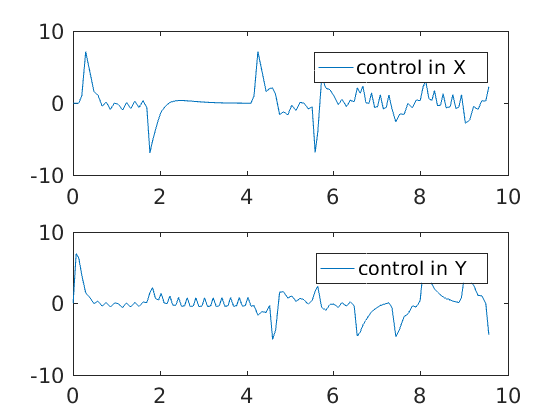

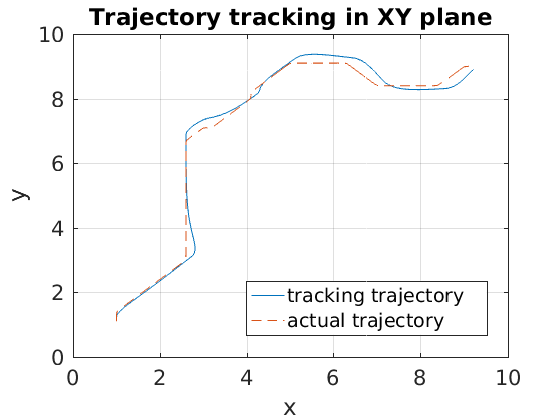

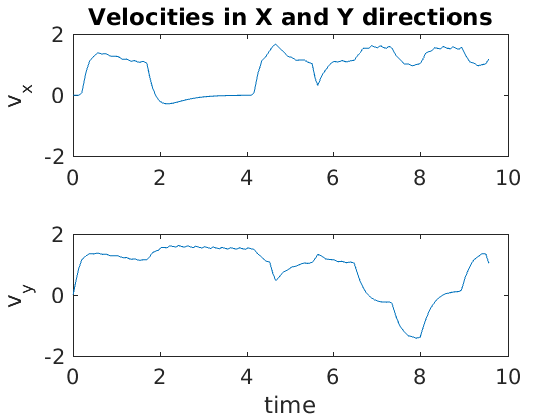

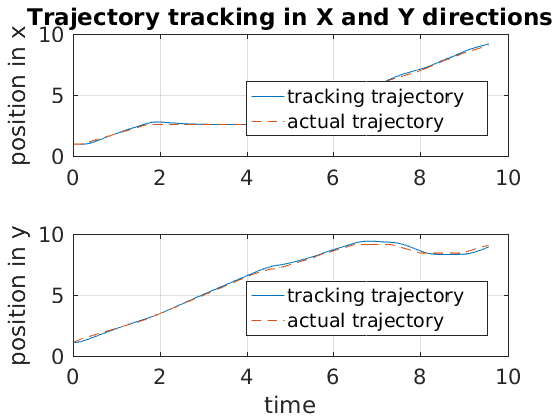

In [1]:
clc
clear all
close all
% This program combines the control and observer using seperation principle
% Controller is designed as u = -K(x - x_des)
% Full state observability is combined to the above control law


A = [0 0 1 0; 0 0 0 1; 0 0 0 0; 0 0 0 0];
B = [0 0; 0 0; 1 0; 0 1];
C = [1 0 0 0; 0 1 0 0];
p_obs = [-10;-11;-12;-13];

L_t = place(A',C',p_obs);
L = L_t';

p = [-2;-2.5;-3;-3.5];
K = place(A,B,p);
[v,d] = eig(A-B*K);

way_pts = load('smooth_way_points.txt');
tspan = way_pts(:,1);
x_des = way_pts(:,2);
y_des = way_pts(:,3);

w1 = 2;
w2 = 1;

control = @(t,x,i)[-K*(x - [x_des(i);y_des(i);(x_des(i)-x_des(i-1))/(tspan(i)-tspan(i-1));(y_des(i)-y_des(i-1))/(tspan(i)-tspan(i-1))] )];
Tspan = 0:0.1:25;
x0 = [x_des(1);y_des(1);0;0];

tt = tspan';
xx = zeros(4,length(tt));
xx(:,1) = [x_des(1);y_des(1);0;0];
X(:,1) = [1;1;0;0];
y(:,1) = C*xx(:,1);
X_hat(:,1) = [0;0;0;0];
y_hat(:,1) = C*X_hat;


for i = 2:length(tt)
    dt = tt(i) - tt(i-1);
    u(:,i) = control(tt(i),xx(:,i-1),i);
    xx(:,i) = xx(:,i-1) + dt*(A*xx(:,i-1)+B*u(:,i));
    
    y(:,i) = C*xx(:,i);

    X_hat(:,i) = X_hat(:,i-1)  +dt * (A*X_hat(:,i-1) + B*u(:,i) +L*(y(:,i-1)-y_hat(:,i-1)));
    y_hat(:,i) = C*X_hat(:,i);
    
    
end

figure;
subplot(2,1,1)
plot(tt,xx(1,:),tt,x_des,'--')
ylabel('position in x')
legend('tracking trajectory', 'actual trajectory','Location','SouthEast')
title('Trajectory tracking in X and Y directions')
grid on
subplot(2,1,2)
plot(tt,xx(2,:),tt,y_des,'--')
legend('tracking trajectory', 'actual trajectory','Location','SouthEast')
xlabel('time')
ylabel('position in y')
grid on

figure;
subplot(2,1,1)
plot(tt,xx(3,:))
title('Velocities in X and Y directions')
ylabel('v_x')
subplot(2,1,2)
plot(tt,xx(4,:))
xlabel('time')
ylabel('v_y')

figure;
plot(xx(1,:),xx(2,:),x_des,y_des,'--')
title('Trajectory tracking in XY plane')
xlabel('x')
ylabel('y')
legend('tracking trajectory', 'actual trajectory','Location','SouthEast')
grid on

figure;
subplot(2,1,1)
plot(tt,u(1,:))
legend('control in X')
subplot(2,1,2)
plot(tt,u(2,:))
legend('control in Y')

### 8. Summery and Conclusion

We designed the controller and observer for a mobile robot which has two inputs $u = [u_x \quad u_y]$. We first get the system dynamics equation and then designed a control law that tracks a desired trajectory without colling with obstacles. Next we design an observer and tested it with a different initial conditions. Finally we combined the observer and controller to track the dessired trajectory.

### 9. Future Work

As can be seen from the figure(1) above that the magnitude of the control signal is above the maximum limit , 1 to -1, in future we can solve using collocation method including actuator limitations as a constraints.